In [2]:
from cpclasses import *

In [62]:
lennard_jones_calc = LennardJones()
def create_initial_cluster(Nouter, Ninner, inner_circle = True):

    thetas = np.linspace(0,2*np.pi,Nouter,endpoint=False)
    pos = [ Nouter / 2 / np.pi * np.array([np.cos(theta),np.sin(theta)]) for theta in thetas]
    
    static = [True for i in range(Nouter)]

    if inner_circle:
        thetas = np.linspace(0,2*np.pi,Ninner,endpoint=False)
        pos += [1.2* Ninner / 2 / np.pi * np.array([np.cos(theta),np.sin(theta)]) for theta in thetas]
        static += [False for i in range(Ninner)]

    return AtomicCluster(lennard_jones_calc,pos=pos,
                         static=static)


[(-10.0, 10.0), (-10.0, 10.0), None]

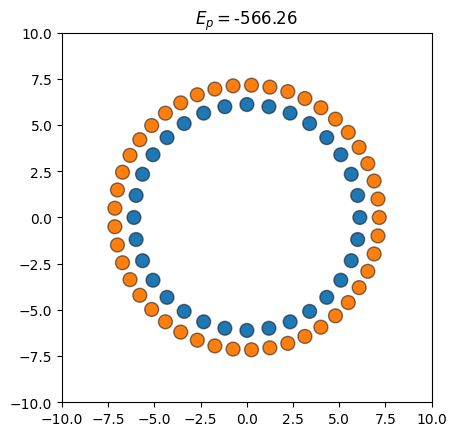

In [63]:
cluster = create_initial_cluster(45, 32)

fig, ax = plt.subplots()

cluster.draw(ax)

ax.set(xlim= (-10, 10), ylim = (-10, 10), aspect='equal')

In [64]:
relax(cluster, 1000, 0.01)

[(-10.0, 10.0), (-10.0, 10.0), None]

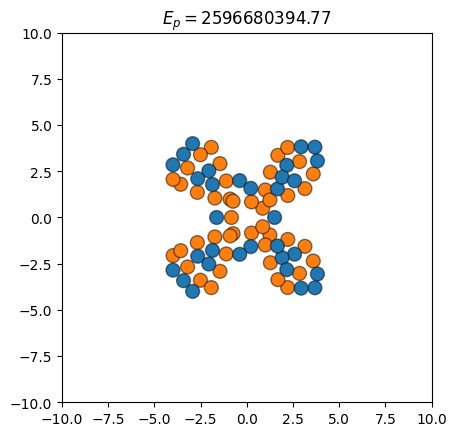

In [65]:
fig, ax = plt.subplots()

cluster.draw(ax)

ax.set(xlim= (-10, 10), ylim = (-10, 10), aspect='equal')